In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from script.NeuralNets.Networks import SequentialNN
from script.ZonotopePropagation.Zonotope import Zonotope
from script.ZonotopePropagation.ZonotopePropagation import ZonotopePropagator
from script.DHOV.Sampling.SamplingStrategy import SamplingStrategy
from script.settings import data_type, device


In [2]:
# need 4 args for 5 layers?
model = SequentialNN([2, 2, 2, 2])
model

SequentialNN(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=2, bias=True)
  (3): ReLU()
  (4): Linear(in_features=2, out_features=2, bias=True)
)

In [3]:
with torch.no_grad():
    model[0].weight = nn.Parameter(torch.tensor([[1, 1], [1, -1.]]))
    model[0].bias   = nn.Parameter(torch.zeros(2))

    model[2].weight = nn.Parameter(torch.tensor([[1, 1], [1, -1.]]))
    model[2].bias   = nn.Parameter(torch.tensor([-0.5, 0]))

    model[4].weight = nn.Parameter(torch.tensor([[-1, 1], [0, 1.]]))
    model[4].bias   = nn.Parameter(torch.tensor([3., 0]))

In [4]:
zp = ZonotopePropagator(model)

In [5]:
lbs = torch.tensor([-1., -1])
ubs = torch.tensor([1., 1])
z = zp.propagate(lbs, ubs, dtype=torch.float32)

print(z.center)
z.generators.T

propagating linear layer
propagating ReLU layer
propagating linear layer
propagating ReLU layer
propagating linear layer
tensor([2.7188, 0.5000], grad_fn=<ViewBackward0>)


tensor([[-0.6250,  0.5000, -0.0625, -0.5625, -0.4688,  0.5000],
        [ 0.0000,  0.5000,  0.2500, -0.2500,  0.0000,  0.5000]],
       grad_fn=<PermuteBackward0>)

# Sampling Methods

In [75]:
def sample_direction(d, z):
    """
    Finds point that maximizes d^T x for x in zonotope z.

    Just linearly transforms the zonotope in direction d,
    then calculates the maximizer for that 1d zonotope and 
    applies that maximizer to the original zonotope z.

    args:
        d - an (n x 1) tensor for an n dimensional zonotope z 
            the direction to maximize in
        z - the zonotope to maximize over

    returns:
        p_out - (n x 1) tensor, point in z that maximizes d^T x for x in z
    """
    z_sample = zp.propagate_linear(d.T, torch.tensor([0.]), z)
    x_hat = torch.where(z_sample.generators > 0, 1., -1.)
    p_out = x_hat.T @ z.generators + z.center

    return p_out.reshape(-1, 1)

In [136]:
def sample_directions(D, z):
    """
    Finds points that maximize d^T x for x in zonotope z and d = D[i,:]

    returns:
        P - (n x d) one column for each sample point
    """
    n_samples = D.shape[0]
    z_sample = zp.propagate_linear(D, torch.zeros(n_samples), z)
    X_hat = torch.where(z_sample.generators > 0, 1., -1.)

    P = z.generators.T @ X_hat + z.center.reshape(-1, 1)
    return P

## Sampling Single Points

In [88]:
n_samples = 100
dirs = torch.randn((2, n_samples))
ps = []
for i in range(n_samples):
    d = dirs[:,i].reshape(-1, 1)
    p = sample_direction(d, z)
    ps.append(p)

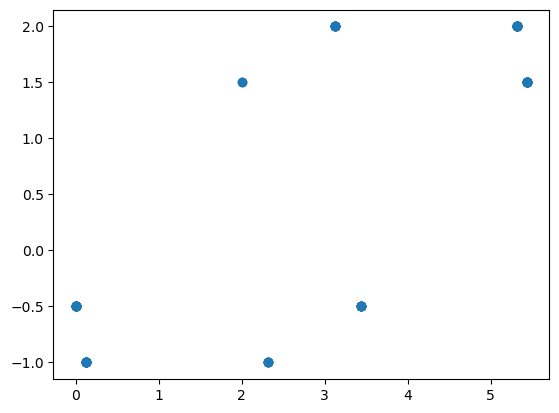

In [89]:
xs = [p[0,0].detach().numpy() for p in ps]
ys = [p[1,0].detach().numpy() for p in ps]

plt.scatter(xs, ys)

## Simultaneously Sampling Many Points

In [138]:
D = torch.randn((100, 2))

P = sample_directions(D, z)

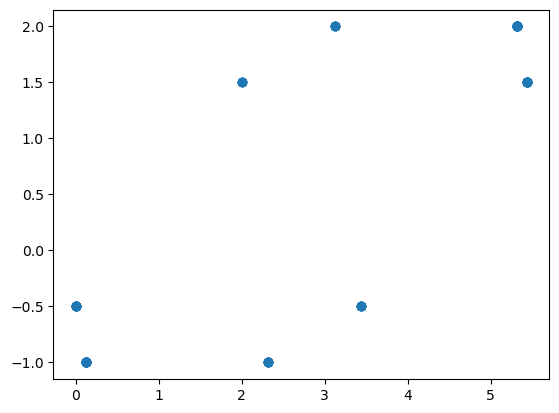

In [141]:
xs = P[0,:].detach().numpy()
ys = P[1,:].detach().numpy()

plt.scatter(xs, ys)

Now integrated into the `Zonotope` class

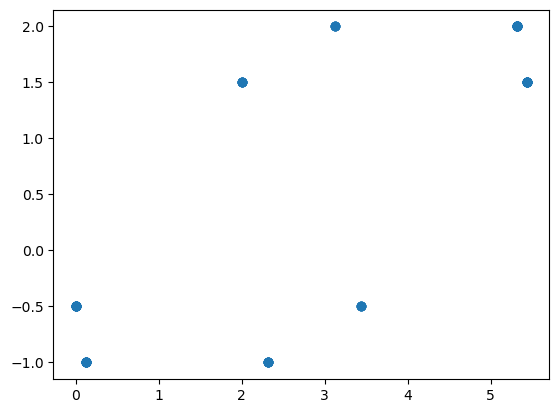

In [8]:
P = z.sample_boundary()

xs = P[0,:].detach().numpy()
ys = P[1,:].detach().numpy()

plt.scatter(xs, ys)

In [6]:
z[0:2]

Zonotope(center=tensor([2.7188, 0.5000], grad_fn=<SliceBackward0>), generators=tensor([[-0.6250,  0.0000],
        [ 0.5000,  0.5000],
        [-0.0625,  0.2500],
        [-0.5625, -0.2500],
        [-0.4688,  0.0000],
        [ 0.5000,  0.5000]], grad_fn=<SliceBackward0>))

# Implement SamplingStrategy Interface

In [ ]:
class ZonotopeSamplingStrategy(SamplingStrategy):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        in_lbs = self.center - self.eps
        in_ubs = self.center + self.eps
        self.zono = Zonotope.from_bounds(in_lbs, in_ubs, shape=(len(in_lbs),), dtype=data_type)

    def sampling_by_round(self, affine_w, affine_b, group_indices, gurobi_model, current_layer_index, bounds_affine_out,
                          bounds_layer_out, list_of_icnns):
        """
        Use this method to sample data points for one layer for all groups.
        Args:
         list_of_icnns:
            affine_w: the weight matrix of the current layer
            affine_b: the bias vector of the current layer
            group_indices: the index of the neuron to be sampled, for all groups
            gurobi_model: the gurobi model to be used for sampling
            current_layer_index: the index of the current layer
            bounds_affine_out: the bounds of the affine output space of the all layers
            bounds_layer_out: the bounds of the activation output space of the all layers

        Returns: list of tuple of included_space, ambient_space

        """
        z = ZonotopePropagator.propagate_linear(affine_w, affine_b, self.zono)

        n_included, n_ambient = self.get_num_of_samples()
        included_samples = []
        ambient_samples = []
        for group in group_indices:
            z_group = z[group]
            P = z_group.sample_boundary(n_samples=n_included)
            included_samples.append(nn.functional.relu(P.T))

            lb = bounds_layer_out[group][0]
            ub = bounds_layer_out[group][1]
            A = torch.rand((n_ambient, len(group))) * (ub - lb) + lb

        lb = bounds_affine_out[0]
        ub = bounds_affine_out[1]

        self.zono = ZonotopePropagator.propagate_relu(z, lb=lb, ub=ub)


In [13]:
torch.rand(10) *2 - 1

tensor([-0.1770, -0.0509,  0.3449,  0.6180, -0.5751,  0.0913,  0.5259, -0.7858,
        -0.5699,  0.6955])

In [20]:
# want uniformly distributed rands in [-1, 1] x [-2, 2]
torch.rand((2, 5)) * torch.tensor([2, 4]).reshape(-1, 1) + torch.tensor([-1, -2]).reshape(-1, 1)

tensor([[-0.8739, -0.4798, -0.4827,  0.1728, -0.8961],
        [ 0.8641, -1.5368, -1.4841,  0.9731,  1.6087]])

In [9]:
torch.maximum(torch.tensor([1,2,3,4,4]), torch.tensor([2,3,3,4,5]))

tensor([2, 3, 3, 4, 5])

In [ ]:
def sampling_by_round(z, affine_w, affine_b, group_indices, gurobi_model, current_layer_index, bounds_affine_out,
                          bounds_layer_out, list_of_icnns):
        """
        Use this method to sample data points for one layer for all groups.
        Args:
         list_of_icnns:
            affine_w: the weight matrix of the current layer
            affine_b: the bias vector of the current layer
            group_indices: the index of the neuron to be sampled, for all groups
            gurobi_model: the gurobi model to be used for sampling
            current_layer_index: the index of the current layer
            bounds_affine_out: the bounds of the affine output space of the all layers
            bounds_layer_out: the bounds of the activation output space of the all layers

        Returns: list of tuple of included_space, ambient_space

        """
        